In [30]:
import os
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
import shutil
import torch.nn.functional as F
import random
import torch
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from segmentation_models_pytorch import utils
import segmentation_models_pytorch as smp
import cv2
from tqdm import tqdm
from typing import List, Optional
from rasterio.windows import Window
import re
from rasterio.transform import from_origin


In [31]:
def image_padding(image, target_size: int = 256, constant_value: int = 255):
    if image.ndim == 2: 
        height, width = image.shape
        image = image[np.newaxis, :, :]  
    elif image.ndim == 3:  
        height, width = image.shape[1:3]
    else:
        raise ValueError("Unexpected image shape: {}".format(image.shape))

    pad_height = max(0, target_size - height)
    pad_width = max(0, target_size - width)
    padded_image = np.pad(image, 
                          ((0, 0), (0, pad_height), (0, pad_width)), 
                          mode='constant', constant_values=constant_value)
    return padded_image

class water_segmentation:
    class WaterDataset(Dataset):
        def __init__(self, img_path, mask_path, file_names):
            self.img_path = img_path
            self.mask_path = mask_path
            self.file_names = file_names

        def __len__(self):
                return len(self.file_names)

        def __getitem__(self, idx):
            with rasterio.open(self.img_path + self.file_names[idx] + '.tif') as fin:
                image = fin.read()
            image = image_padding(image).astype(np.float32)

            with rasterio.open(self.mask_path + self.file_names[idx] + '.tif') as fin:
                mask = fin.read(1)
            mask = image_padding(mask)


            # Преобразуем тип данных изображения в float32
            image = image.astype(np.float32)
            image = torch.from_numpy(image)

            # Преобразуем тип данных маски в long
            mask = mask.astype(np.uint8)
            mask = torch.from_numpy(mask).long()
            mask = mask.unsqueeze(0)
            return image, mask
        

    def __init__(self, model_path: str) -> None:
        self.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = torch.jit.load(model_path, map_location=self.DEVICE)
        self.image_path = None
        self.OVERLAP = 0
        self.SIZE = 256


    def predict(self, image_path: str, image_id: str = 0, image_size: int = 256):
        self.image_path = image_path
        self.SIZE = image_size
        self.ID = image_id
        with rasterio.open(image_path) as src_image:
                self.IMG_WIDTH = src_image.width
                self.IMG_HEIGHT = src_image.height

        self._split_image(
            image_path=image_path,
            output_folder="Buffer/",
            tile_size=image_size,
            overlap=self.OVERLAP,
            image_id=image_id
        )

        data_list = self._get_data_list(f'Buffer/images/', delete=False)
        predicted_masks = self._predict_tiels(data_list)
        reconstructed_image = self._reconstruct_image_from_tiles(
            tiles=predicted_masks,
            image_height=self.IMG_HEIGHT,
            image_width=self.IMG_WIDTH,
            tile_size=self.SIZE,
            overlap=self.OVERLAP
        )
        reconstructed_image = self._noise(reconstructed_image)
        
        return reconstructed_image



    def _noise(self, data):
        kernel_ellipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
        denoised_mask = cv2.morphologyEx(data, cv2.MORPH_CLOSE, kernel_ellipse)
        return denoised_mask


    def _reconstruct_image_from_tiles(self, tiles, image_height, image_width, tile_size, overlap):

        step_size = tile_size - overlap
        reconstructed_image = np.zeros((image_height, image_width), dtype=np.float32)
        weight_map = np.zeros((image_height, image_width), dtype=np.float32)

        index = 0
        for y in range(0, image_height, step_size):
            for x in range(0, image_width, step_size):
                tile = tiles[index]
                h, w = tile.shape


                y1, y2 = y, min(y + tile_size, image_height)
                x1, x2 = x, min(x + tile_size, image_width)


                tile_h, tile_w = y2 - y1, x2 - x1
                tile_crop = tile[:tile_h, :tile_w]


                np.add.at(reconstructed_image, (slice(y1, y2), slice(x1, x2)), tile_crop)
                np.add.at(weight_map, (slice(y1, y2), slice(x1, x2)), 1)

                index += 1

    
        reconstructed_image = (reconstructed_image / np.maximum(weight_map, 1)).astype(np.uint8)
        self._save_array_to_tiff(reconstructed_image, f'train\example_preds\output{self.ID}.tif')
        self._clear_buffer()
        
        return reconstructed_image




    def _save_array_to_tiff(self, array, output_path, reference_tiff_path=None) -> None:
       
        if reference_tiff_path:
            with rasterio.open(reference_tiff_path) as src:
                profile = src.profile
                transform = src.transform
        else:
           
            transform = from_origin(0, 0, 1, 1)  
            profile = {
                'driver': 'GTiff',
                'height': array.shape[0],
                'width': array.shape[1],
                'count': 1,  
                'dtype': array.dtype,
                'transform': transform,
                'crs': 'EPSG:4326'  
            }

        # Сохраняем массив как TIFF
        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(array, 1)  

    def _predict_tiels(self, data_list: list[str]):
        pred_ds = self.WaterDataset(
            img_path=f'Buffer/images/',
            mask_path=f'Buffer/images/',
            file_names=data_list
        )

        predicted_masks = []
        for i in range(len(data_list)):
            image, _ = pred_ds[i]
            image, original_size = self._image_padding_predict(image)
            image = image.astype(np.float32)
            x_tensor = image.to(self.DEVICE).unsqueeze(0) if isinstance(image, torch.Tensor) else torch.from_numpy(image).to(self.DEVICE).unsqueeze(0)

            pr_mask = self.model(x_tensor)
            pr_mask = pr_mask.squeeze().cpu().detach().numpy()

            binary_output = (pr_mask > 0.5).astype(int)
            binary_output = binary_output[:original_size[0], :original_size[1]]
            predicted_masks.append(torch.from_numpy(binary_output))


        return predicted_masks

    def _image_padding_predict(self, image, target_size: int = 256):
        height, width = image.shape[1:3]
        pad_height = max(0, target_size - height)

        pad_width = max(0, target_size - width)
        padded_image = np.pad(image, ((0, 0), (0, pad_height),
                                      (0, pad_width)), mode='reflect')
        
        return padded_image, (height, width)  


    def _image_padding(self, image, target_size: int = None, constant_value: int = 255):
        target_size = 256
        if image.ndim == 2: 
            height, width = image.shape
           
            image = image[np.newaxis, :, :]  
        elif image.ndim == 3:  
            height, width = image.shape[1:3]
        else:
            raise ValueError("Unexpected image shape: {}".format(image.shape))

        pad_height = max(0, target_size - height)
        pad_width = max(0, target_size - width)
        padded_image = np.pad(image, 
                              ((0, 0), (0, pad_height), (0, pad_width)), 
                              mode='constant', constant_values=constant_value)
        return padded_image


    def _get_tiles_with_overlap(self, image_width: int, image_height: int, 
                           tile_size: int, overlap: int) -> List[Window]:

        step_size = tile_size - overlap
        tiles = []
        for y in range(0, image_height, step_size):
            for x in range(0, image_width, step_size):
                window = Window(x, y, tile_size, tile_size)
                # Adjust window if it exceeds the image bounds
                window = window.intersection(Window(0, 0, image_width, image_height))
                tiles.append(window)
        return tiles


    def _save_tiles(self, src_dataset: rasterio.io.DatasetReader, window: Window, 
                  output_folder: str, tile_index: int, image_id: int) -> None:
    
        transform = src_dataset.window_transform(window)
        tile_data = src_dataset.read(window=window)
        
        profile = src_dataset.profile
        profile.update({
            'driver': 'GTiff',
            'height': window.height,
            'width': window.width,
            'transform': transform
        })
        
        output_filename = os.path.join(output_folder, f"tile_{image_id}_{tile_index}.tif")
        with rasterio.open(output_filename, 'w', **profile) as dst:
            dst.write(tile_data)
            

    def _split_image(self, image_path: str, output_folder: str, mask_path: Optional[str] = None, 
                    tile_size: int = 256, overlap: int = 0, image_id: int = 0) -> None:
        with rasterio.open(image_path) as src_image:
            image_width = src_image.width
            image_height = src_image.height
    
            images_folder = os.path.join(output_folder, 'images')
            os.makedirs(images_folder, exist_ok=True)

            tiles = self._get_tiles_with_overlap(image_width, image_height, tile_size, overlap)
            for idx, window in tqdm(enumerate(tiles)):
                self._save_tiles(src_image, window, images_folder, idx, image_id)


    def _image_padding(self, image, target_size: int = None, constant_value: int = 255):
        target_size = self.SIZE
        if image.ndim == 2: 
            height, width = image.shape
           
            image = image[np.newaxis, :, :]  
        elif image.ndim == 3:  
            height, width = image.shape[1:3]
        else:
            raise ValueError("Unexpected image shape: {}".format(image.shape))
        pad_height = max(0, target_size - height)
        pad_width = max(0, target_size - width)
        padded_image = np.pad(image, 
                              ((0, 0), (0, pad_height), (0, pad_width)), 
                              mode='constant', constant_values=constant_value)
        return padded_image


    def _get_data_list(self, img_path, delete: Optional[bool] = True):
        name = []
        for _, _, filenames in os.walk(img_path):  # given a directory iterates over the files
            for filename in filenames:
                f = filename.split('.')[0]
                name.append(f)

        # Создаем DataFrame с двумя столбцами: текстовая часть и числовая часть
        df = pd.DataFrame(name, columns=['id'])

        # Извлекаем числовую часть и добавляем в отдельный столбец
        df['number'] = df['id'].str.extract(r'_(\d+)$')[0].astype(int)

        # Сортируем по текстовой части и числовой части
        df = df.sort_values(by=['number']).reset_index(drop=True)

        # Получаем отсортированные имена файлов
        sorted_names = df['id'].values

        if delete:
            return np.delete(sorted_names, 0)
        else:
            return sorted_names
        
    def _clear_buffer(self):
        buffer_path = "Buffer"
        if os.path.exists(buffer_path):
            shutil.rmtree(buffer_path)  
        os.makedirs(buffer_path) 


    

In [32]:
WaterSeg = water_segmentation('model_machine/Linknet.pt')
ID = '4' #необхожимо установить ID другой фотографии
pred_mask = WaterSeg.predict(f'test_scoltech/images/{ID}.tif', ID) # Пожалуйста, введи сюда путь до файла, который хотите обработать

200it [00:01, 105.57it/s]
c:\Users\Bigil\OneDrive\Рабочий стол\CP\myenv\lib\site-packages\rasterio\__init__.py:378: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


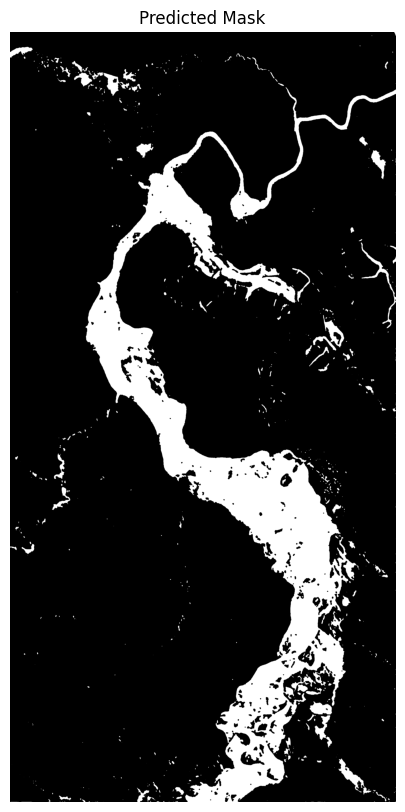

In [29]:
plt.figure(figsize=(10, 10)) 

plt.imshow(pred_mask, cmap='gray') 
plt.axis('off') 
plt.title('Predicted Mask')  
plt.show()  